In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns

from wind_dir_classifier import load_netcdf
from models import data_prep, evaluate, cross_corr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import TimeDistributed
from sklearn.metrics import f1_score
from tensorflow import keras

In [2]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

In [3]:
# loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/ERA5_single_location')

df['wd_10'] = np.arctan2(df['v10'], df['u10'])
df['wd_100'] = np.arctan2(df['v100'], df['u100'])

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [4]:
df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

In [5]:
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100,wd_10,wd_100
0,262.714033,259.900872,103298.015394,0.000000,0.0,1950-01-01 00:00:00,2.489513,3.817744,-1.311705,-1.331830
1,260.695745,258.184905,103401.866726,0.000000,0.0,1950-01-01 01:00:00,1.837656,3.726080,-1.044746,-1.156429
2,260.195929,257.699157,103434.928307,0.000000,0.0,1950-01-01 02:00:00,2.599009,3.537574,-0.907942,-1.022619
3,259.350219,256.948053,103418.318422,0.000000,0.0,1950-01-01 03:00:00,2.534284,3.147813,-0.766478,-0.868955
4,258.763065,256.665744,103419.030274,0.000000,0.0,1950-01-01 04:00:00,2.623488,3.713367,-0.709885,-0.816194
...,...,...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,0.0,2020-12-31 19:00:00,0.809895,1.810642,-2.144703,-2.110360
622388,274.719036,274.144356,100973.148236,0.000005,0.0,2020-12-31 20:00:00,0.868971,1.490224,-2.063162,-2.186959
622389,274.310849,273.971416,100980.668096,0.000003,0.0,2020-12-31 21:00:00,0.774225,1.328229,-2.055575,-2.151857
622390,273.450250,273.092257,100972.962561,0.000002,0.0,2020-12-31 22:00:00,0.649268,0.561700,-1.691702,-1.628719


# Regresja

## 1h

In [11]:
lookback = 24
future = 1
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100')
y_index = 8

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            LSTM(24, activation='relu', return_sequences=True),
            LSTM(24, activation='relu'),
            Dense(1)
        ])

class mean_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-1])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

In [14]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0304
Epoch 2/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0207
Epoch 3/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0190
Epoch 4/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0183
Epoch 5/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0178
Epoch 6/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0174
Epoch 7/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.0172
Epoch 8/20
2191/2191 [==============================] - 12s 6ms/step - loss: 0.0170
Epoch 9/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0170
Epoch 10/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0168
Epoch 11/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0167
Epoch 12/20
2191/2191 [==============================] - 9s 4ms/step - loss:

In [15]:
compile_and_fit(lstm, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 47s 20ms/step - loss: 0.0287
Epoch 2/20
2191/2191 [==============================] - 44s 20ms/step - loss: 0.0207
Epoch 3/20
2191/2191 [==============================] - 39s 18ms/step - loss: 0.0200
Epoch 4/20
2191/2191 [==============================] - 39s 18ms/step - loss: 0.0195
Epoch 5/20
2191/2191 [==============================] - 39s 18ms/step - loss: 0.0189
Epoch 6/20
2191/2191 [==============================] - 39s 18ms/step - loss: 0.0183
Epoch 7/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0178
Epoch 8/20
2191/2191 [==============================] - 39s 18ms/step - loss: 0.0175
Epoch 9/20
2191/2191 [==============================] - 39s 18ms/step - loss: 0.0173
Epoch 10/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0169
Epoch 11/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0168
Epoch 12/20
2191/2191 [==============================] - 39s 18

In [16]:
def evaluate_angular(model, X_test, y_test, scaler_y):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(np.square((testYTrue-testPredictions+np.pi)%(2*np.pi)-np.pi).mean())
    
    return testScore

  1/274 [..............................] - ETA: 6s

274/274 [==============================] - 1s 3ms/step
Test Score: 0.7892 RMSE


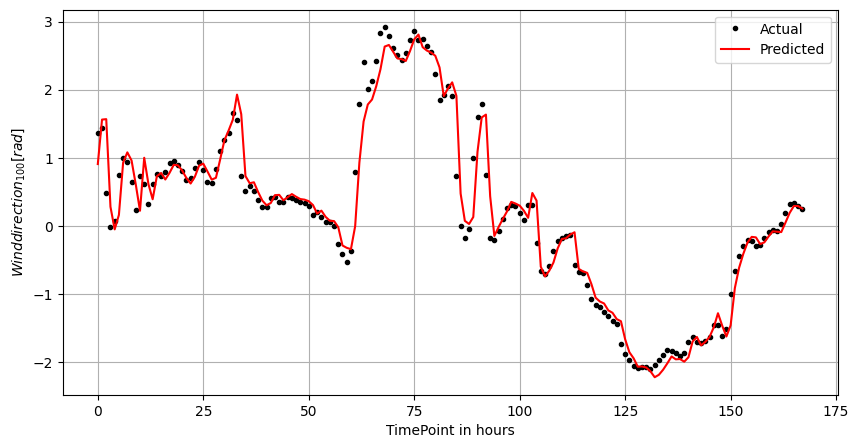

In [31]:
rmse_dense,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/direction_1h_dense_res.png', y_label='$Wind direction_{100}[rad]$')

274/274 [==============================] - 1s 3ms/step


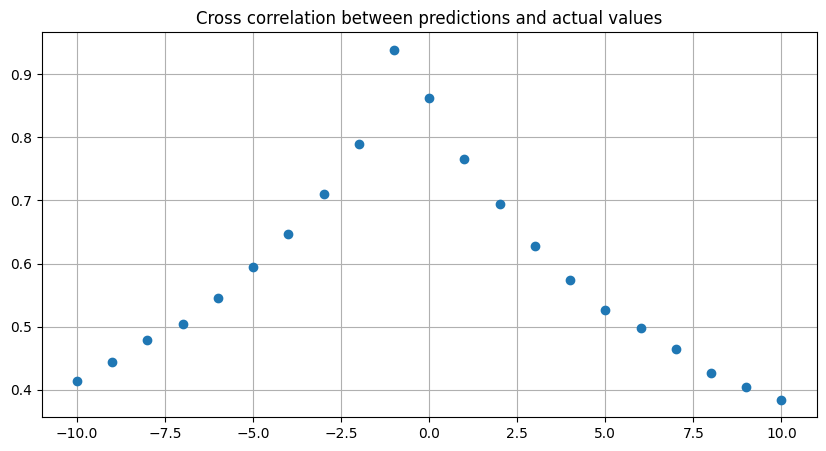

In [24]:
cross_corr(dense, X_test, y_test, scaler_y)

  1/274 [..............................] - ETA: 7s

274/274 [==============================] - 2s 8ms/step
Test Score: 0.7658 RMSE


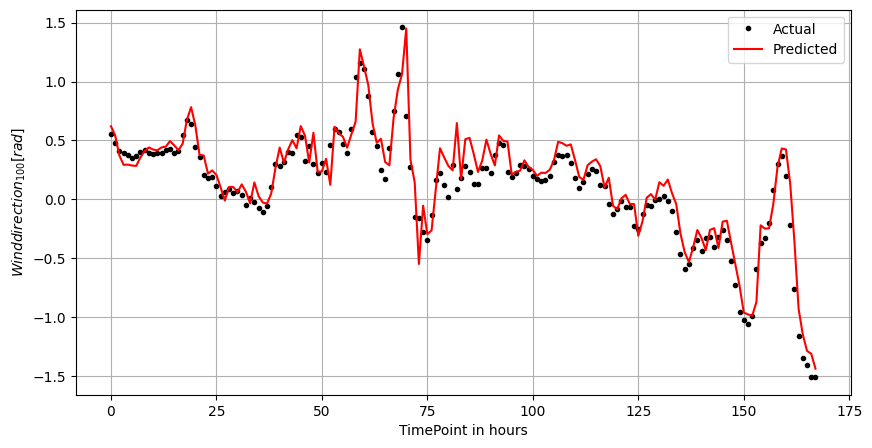

In [33]:
rmse_lstm,_,_ = evaluate(lstm, X_test, y_test, scaler_y, save_to='figures/direction_1h_lstm_res.png', y_label='$Wind direction_{100}[rad]$')

  1/274 [..............................] - ETA: 7s

274/274 [==============================] - 2s 6ms/step


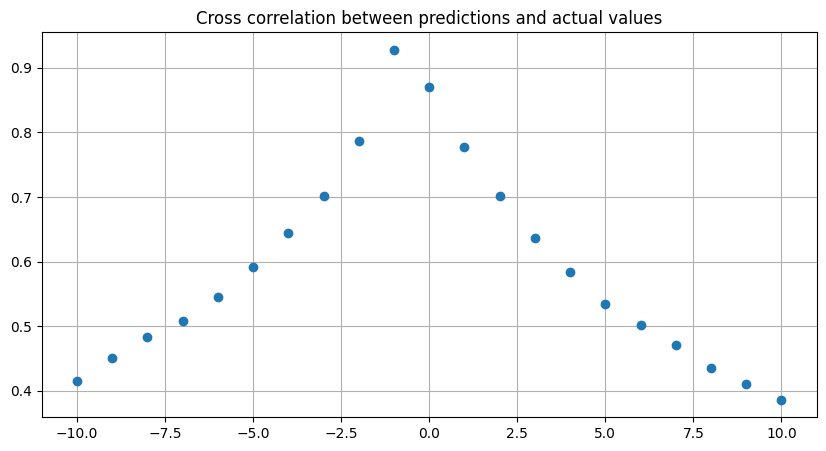

In [34]:
cross_corr(lstm, X_test, y_test, scaler_y)

Test Score: 0.9346 RMSE


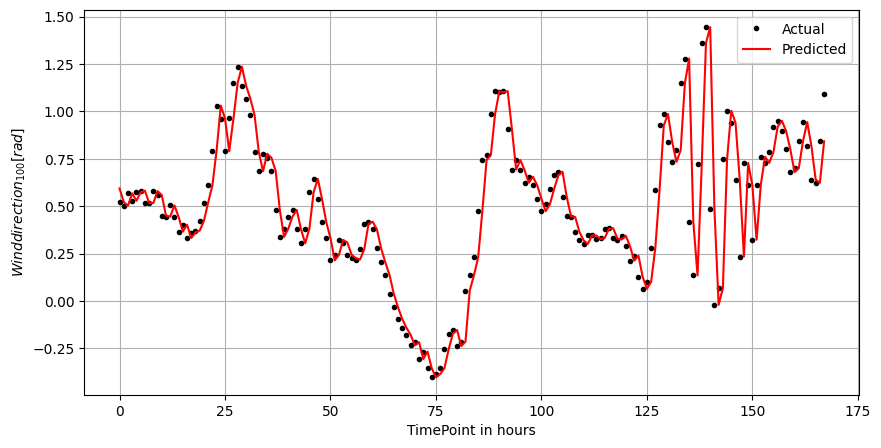

In [35]:
rmse_last,_,_ = evaluate(last, X_test, y_test, scaler_y, save_to='figures/direction_1h_last_res.png', y_label='$Wind direction_{100}[rad]$')

Test Score: 1.3170 RMSE


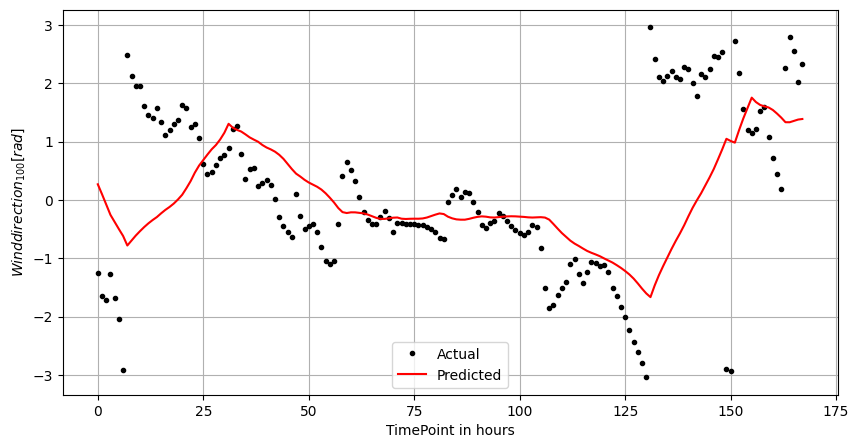

In [36]:
rmse_mean,_,_ = evaluate(mean, X_test, y_test, scaler_y, save_to='figures/direction_1h_mean_res.png', y_label='$Wind direction_{100}[rad]$')

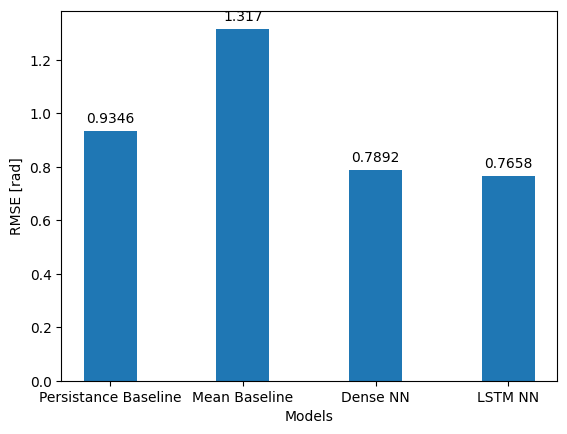

In [37]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [rad]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

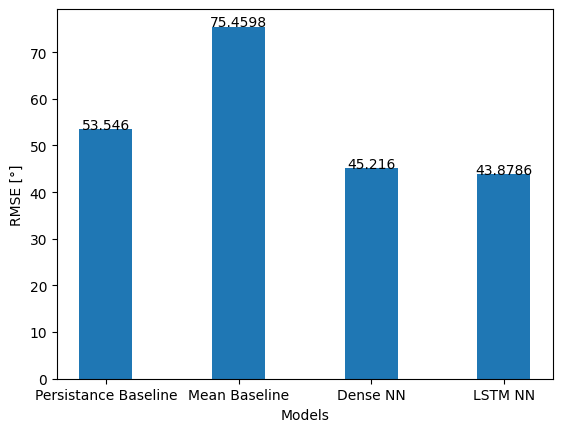

In [38]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]
y = [value*180/np.pi for value in y]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [°]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

## 3h

In [39]:
lookback = 24
future = 3
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100')
y_index = 8

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            LSTM(24, activation='relu', return_sequences=True),
            LSTM(24, activation='relu'),
            Dense(1)
        ])

class mean_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-1])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

In [40]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 13s 5ms/step - loss: 0.0476
Epoch 2/20
2191/2191 [==============================] - 12s 6ms/step - loss: 0.0392
Epoch 3/20
2191/2191 [==============================] - 12s 5ms/step - loss: 0.0367
Epoch 4/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.0353
Epoch 5/20
2191/2191 [==============================] - 14s 6ms/step - loss: 0.0346
Epoch 6/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.0340
Epoch 7/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.0334
Epoch 8/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.0331
Epoch 9/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.0328
Epoch 10/20
2191/2191 [==============================] - 12s 6ms/step - loss: 0.0325
Epoch 11/20
2191/2191 [==============================] - 12s 6ms/step - loss: 0.0324
Epoch 12/20
2191/2191 [==============================] - 13s 6ms/step - lo

In [41]:
compile_and_fit(lstm, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 51s 22ms/step - loss: 0.0434
Epoch 2/20
2191/2191 [==============================] - 47s 21ms/step - loss: 0.0368
Epoch 3/20
2191/2191 [==============================] - 43s 20ms/step - loss: 0.0356
Epoch 4/20
2191/2191 [==============================] - 41s 19ms/step - loss: 0.0344
Epoch 5/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0337
Epoch 6/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0330
Epoch 7/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0325
Epoch 8/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0321
Epoch 9/20
2191/2191 [==============================] - 41s 19ms/step - loss: 0.0318
Epoch 10/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0315
Epoch 11/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0313
Epoch 12/20
2191/2191 [==============================] - 41s 19

274/274 [==============================] - 1s 3ms/step
Test Score: 1.0742 RMSE


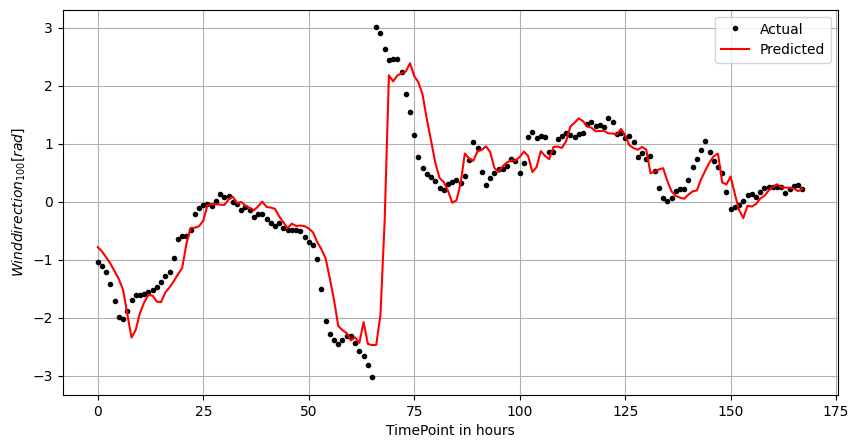

In [42]:
rmse_dense,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/direction_3h_dense_res.png', y_label='$Wind direction_{100}[rad]$')

274/274 [==============================] - 1s 2ms/step


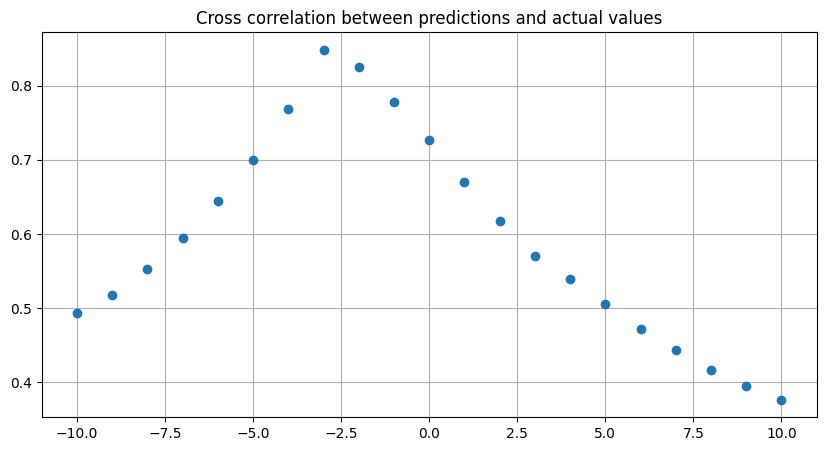

In [43]:
cross_corr(dense, X_test, y_test, scaler_y)

274/274 [==============================] - 2s 8ms/step
Test Score: 1.0600 RMSE


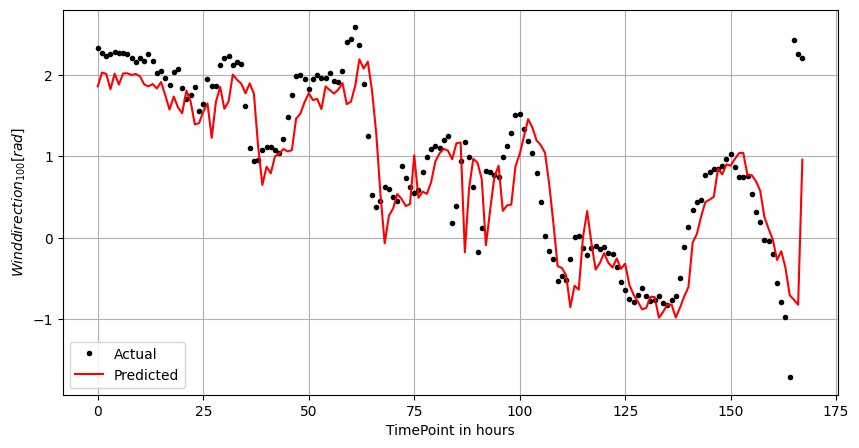

In [46]:
rmse_lstm,_,_ = evaluate(lstm, X_test, y_test, scaler_y, save_to='figures/direction_3h_lstm_res.png', y_label='$Wind direction_{100}[rad]$')

274/274 [==============================] - 2s 7ms/step


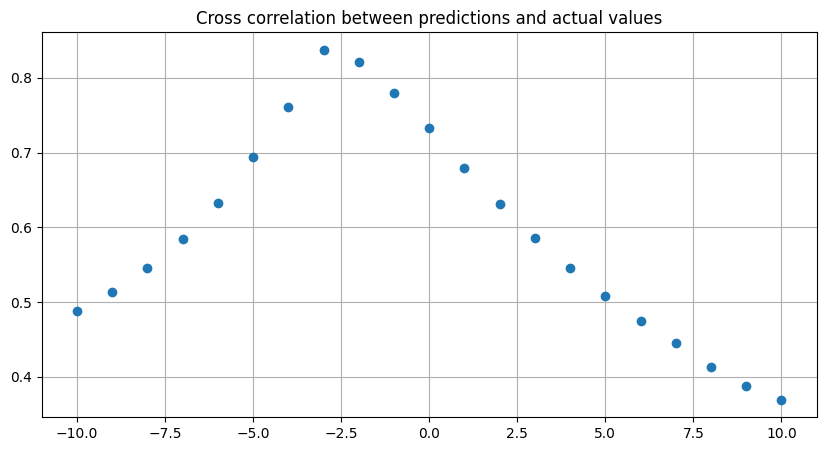

In [47]:
cross_corr(lstm, X_test, y_test, scaler_y)

Test Score: 1.3355 RMSE


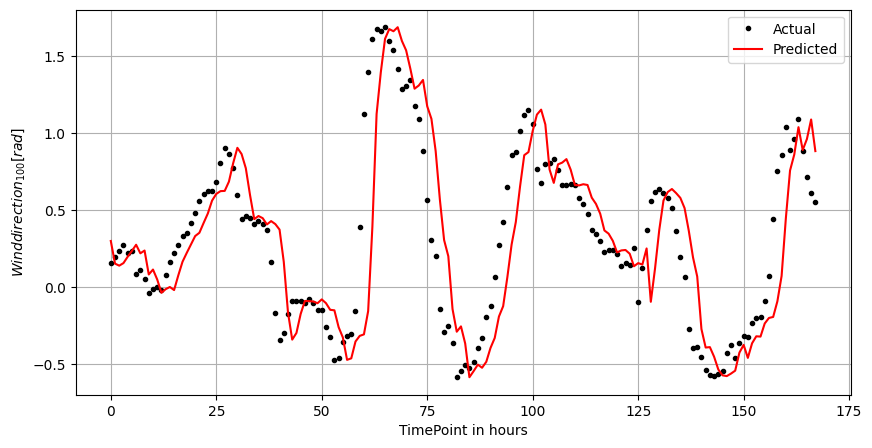

In [48]:
rmse_last,_,_ = evaluate(last, X_test, y_test, scaler_y, save_to='figures/direction_3h_last_res.png', y_label='$Wind direction_{100}[rad]$')

Test Score: 1.3953 RMSE


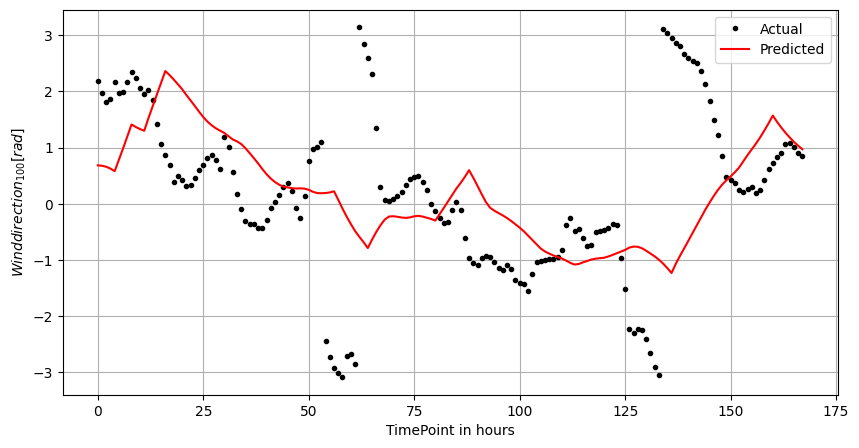

In [49]:
rmse_mean,_,_ = evaluate(mean, X_test, y_test, scaler_y, save_to='figures/direction_3h_mean_res.png', y_label='$Wind direction_{100}[rad]$')

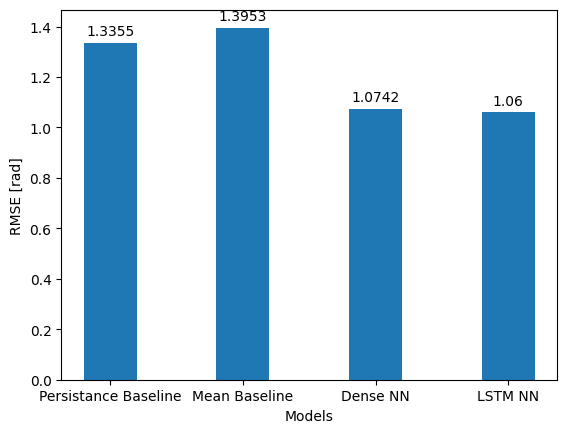

In [50]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [rad]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

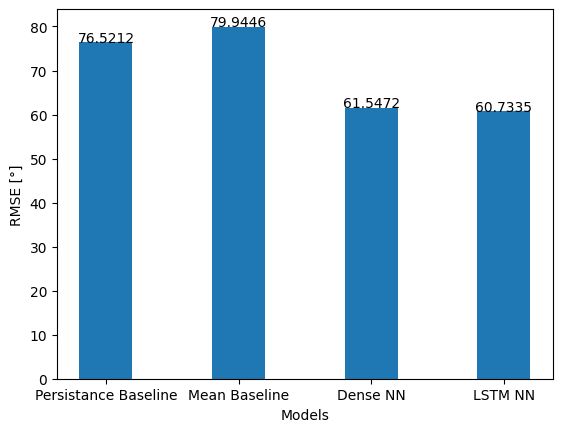

In [51]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]
y = [value*180/np.pi for value in y]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [°]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

## 6h

In [52]:
lookback = 24
future = 6
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100')
y_index = 8

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            LSTM(24, activation='relu', return_sequences=True),
            LSTM(24, activation='relu'),
            Dense(1)
        ])

class mean_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-1])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

In [53]:
compile_and_fit(dense, X_train, y_train)
compile_and_fit(lstm, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0541
Epoch 2/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0476
Epoch 3/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0457
Epoch 4/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0445
Epoch 5/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0438
Epoch 6/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0431
Epoch 7/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0428
Epoch 8/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0422
Epoch 9/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0420
Epoch 10/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0417
Epoch 11/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0414
Epoch 12/20
2191/2191 [==============================] - 11s 5ms/step - loss:

274/274 [==============================] - 1s 2ms/step
Test Score: 1.2529 RMSE


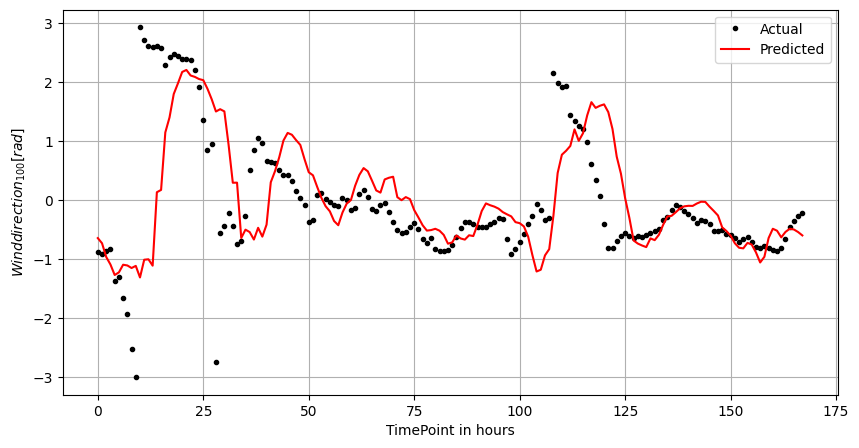

In [54]:
rmse_dense,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/direction_6h_dense_res.png', y_label='$Wind direction_{100}[rad]$')

274/274 [==============================] - 1s 3ms/step


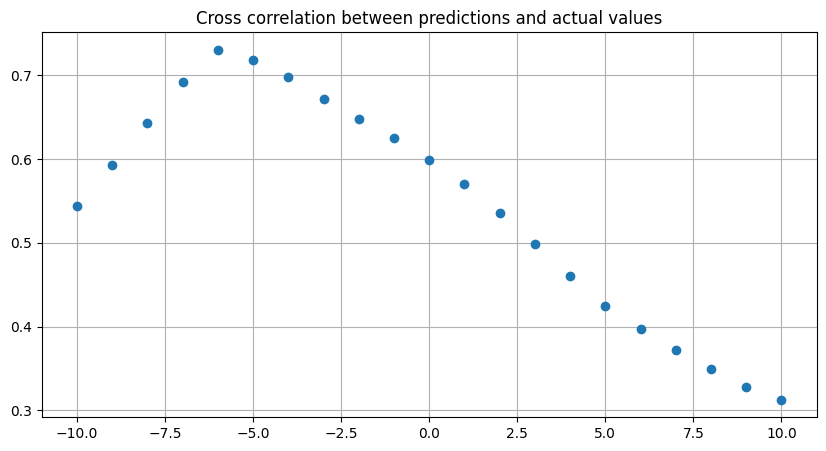

In [55]:
cross_corr(dense, X_test, y_test, scaler_y)

274/274 [==============================] - 3s 8ms/step
Test Score: 1.2253 RMSE


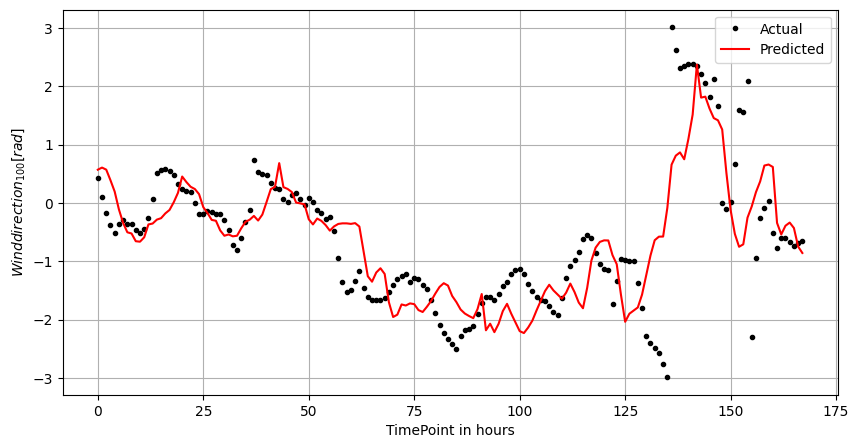

In [56]:
rmse_lstm,_,_ = evaluate(lstm, X_test, y_test, scaler_y, save_to='figures/direction_6h_lstm_res.png', y_label='$Wind direction_{100}[rad]$')

Test Score: 1.5837 RMSE


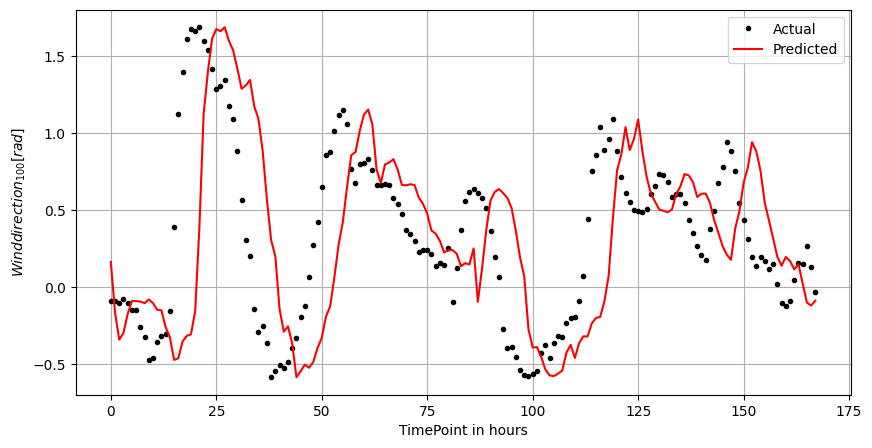

In [58]:
rmse_last,_,_ = evaluate(last, X_test, y_test, scaler_y, save_to='figures/direction_6h_last_res.png', y_label='$Wind direction_{100}[rad]$')

Test Score: 1.4715 RMSE


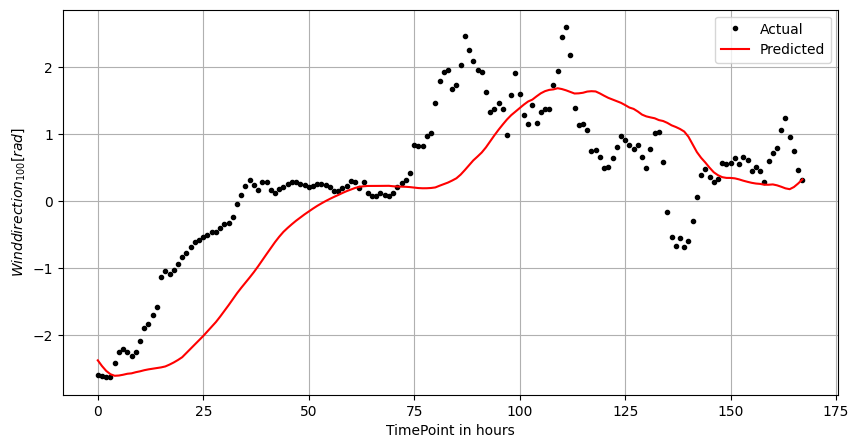

In [59]:
rmse_mean,_,_ = evaluate(mean, X_test, y_test, scaler_y, save_to='figures/direction_6h_mean_res.png', y_label='$Wind direction_{100}[rad]$')

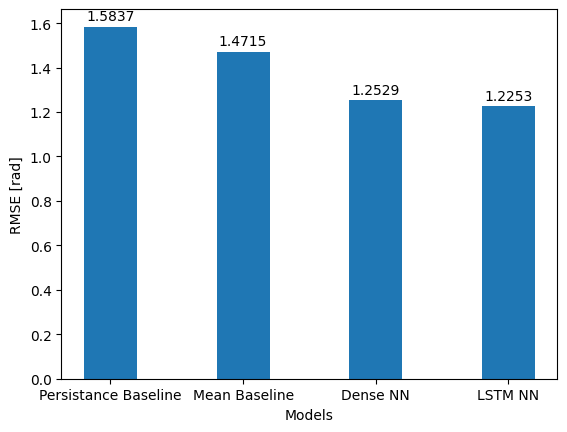

In [60]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [rad]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

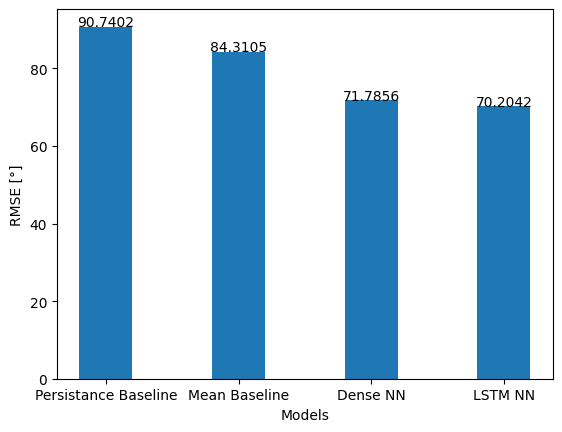

In [61]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]
y = [value*180/np.pi for value in y]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [°]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

In [63]:
dense.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 24, 200)           2800      
                                                                 
 dense_19 (Dense)            (None, 24, 200)           40200     
                                                                 
 dense_20 (Dense)            (None, 24, 200)           40200     
                                                                 
 dense_21 (Dense)            (None, 24, 1)             201       
                                                                 
 reshape_6 (Reshape)         (None, 1, 24)             0         
                                                                 
 dense_22 (Dense)            (None, 1, 1)              25        
                                                                 
 reshape_7 (Reshape)         (None, 1)                

In [64]:
lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 24, 24)            3648      
                                                                 
 lstm_10 (LSTM)              (None, 24, 24)            4704      
                                                                 
 lstm_11 (LSTM)              (None, 24)                4704      
                                                                 
 dense_23 (Dense)            (None, 1)                 25        
                                                                 
Total params: 13,081
Trainable params: 13,081
Non-trainable params: 0
_________________________________________________________________


# Klasyfikacja

In [75]:
noClasses = 8

bins = np.linspace(-np.pi, np.pi, noClasses+1)
labels = range(noClasses)
df['wd_100_cat'] = pd.cut(df['wd_100'], bins=bins, include_lowest=True, labels=labels)

weak_wind_class_limit = df['windspeed_100'].sort_values().iloc[int(len(df)/noClasses)]

df['wd_100_cat'] = df['wd_100_cat'].cat.add_categories(noClasses)
df['wd_100_cat'] = df['wd_100_cat'].where(df['windspeed_100']>weak_wind_class_limit, noClasses)

<AxesSubplot: xlabel='wd_100_cat', ylabel='count'>

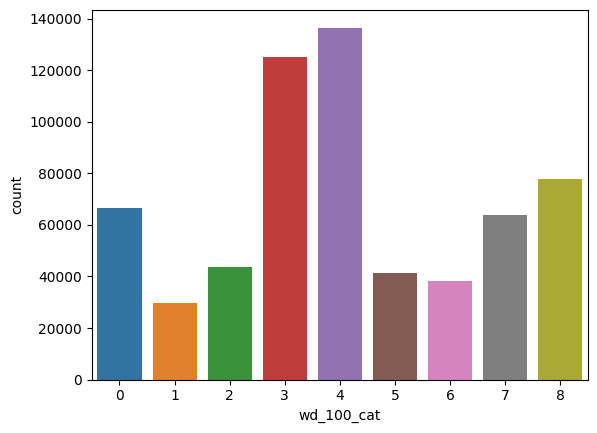

In [76]:
sns.countplot(x=df["wd_100_cat"])

In [8]:
from wind_dir_classifier import data_prep
def compile_and_fit(model, X_train, y_train, X_test, y_test):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=4,
                                                   mode='min')

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping], validation_data=(X_test,y_test), verbose=1)
    return history

In [9]:
from keras.utils import to_categorical

## 1h

In [138]:
lookback = 24
future = 1
X_train, y_train, X_test, y_test = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100_cat')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_outputs = y_train.shape[1]

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dense(n_outputs),
            Reshape([n_outputs*24]),
            Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            LSTM(24, activation='relu', return_sequences=True),
            Dropout(0.2),
            LSTM(24, activation='relu'),
            Dense(n_outputs, activation='softmax')
        ])

In [139]:
compile_and_fit(dense, X_train, y_train, X_test, y_test)
compile_and_fit(lstm, X_train, y_train, X_test, y_test)

Epoch 1/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.8382 - accuracy: 0.7157 - val_loss: 0.6680 - val_accuracy: 0.7817
Epoch 2/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.6284 - accuracy: 0.7971 - val_loss: 0.5823 - val_accuracy: 0.8081
Epoch 3/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.5830 - accuracy: 0.8079 - val_loss: 0.5678 - val_accuracy: 0.8140
Epoch 4/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.5607 - accuracy: 0.8094 - val_loss: 0.5281 - val_accuracy: 0.8174
Epoch 5/20
2191/2191 [==============================] - 13s 6ms/step - loss: 0.5414 - accuracy: 0.8142 - val_loss: 0.5187 - val_accuracy: 0.8225
Epoch 6/20
2191/2191 [==============================] - 14s 6ms/step - loss: 0.5294 - accuracy: 0.8149 - val_loss: 0.5211 - val_accuracy: 0.8198
Epoch 7/20
2191/2191 [==============================] - 14s 6ms/step - loss: 0.5205 - accuracy: 0.8192 - val_loss: 0.5036 - val_ac

In [81]:
from sklearn.metrics import confusion_matrix

In [133]:
def evaluate_classifier(model, X_test, y_test):
    y_test_mod = y_test.flatten().astype('int64')
    correction = ((np.bincount(y_test_mod)/len(y_test_mod))**2).sum()
    _, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)

    y_prediction = model.predict(X_test)
    y_prediction = np.argmax (y_prediction, axis = 1)
    y_true = np.argmax(y_test, axis=1)
    f_score = f1_score(y_true, y_prediction, average='weighted')
    accuracy_corrected = accuracy/correction

    y_test_for_cm = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test_for_cm, y_prediction , normalize='pred')
    sns.heatmap(cm, annot=True)

    print(accuracy, accuracy_corrected, f_score)
    
    return accuracy, accuracy_corrected, f_score

274/274 [==============================] - 1s 2ms/step
0.8258933424949646 1.0291901652629558 0.8260628389206822


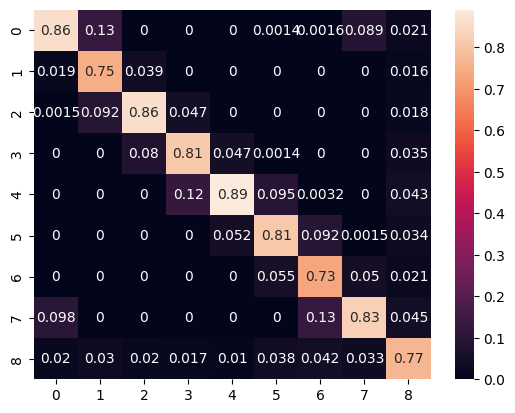

In [140]:
acc_dense, acc_corr_dense, f1_dense = evaluate_classifier(dense, X_test, y_test)

In [10]:
from models import datetimeToSignal, to_supervised

def get_true_test_values(df, testYear, lookback, toFuture, y_featurename):

    test = df[df['Date Time']>='{}-01-01'.format(testYear)]
    test = test[test['Date Time']<'{}-01-01'.format(testYear+1)]

    test = datetimeToSignal(test)
    
    y_index = test.columns.get_loc(y_featurename)

    values_test = test.values

    X_test, y_test = to_supervised(values_test, n_input=lookback, n_out=toFuture, y_index=y_index)

    return y_test

In [11]:
from sklearn.metrics import mean_squared_error
def calculate_classifier_rmse(df, model, X_test, y_test):
    y_true = get_true_test_values(df, 2020, 24, future, 'wd_100')
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)
    mask = y_prediction != 8
    y_prediction = y_prediction[mask]
    y_true = y_true[mask]
    y_prediction = y_prediction*np.pi/4 - (np.pi - np.pi/8)

    rmse_rad = sqrt(mean_squared_error(y_true, y_prediction))
    return rmse_rad
    

In [141]:
rmse_classifier = calculate_classifier_rmse(df, dense, X_test, y_test)
print("RMSE classifier = {} rad = {} °". format(rmse_classifier, rmse_classifier*180/np.pi))

274/274 [==============================] - 1s 2ms/step
RMSE classifier = 0.8217051906994929 rad = 47.0802394310734 °


274/274 [==============================] - 2s 5ms/step
0.792327880859375 0.9873624361478365 0.7916179634158633


(0.792327880859375, 0.9873624361478365, 0.7916179634158633)

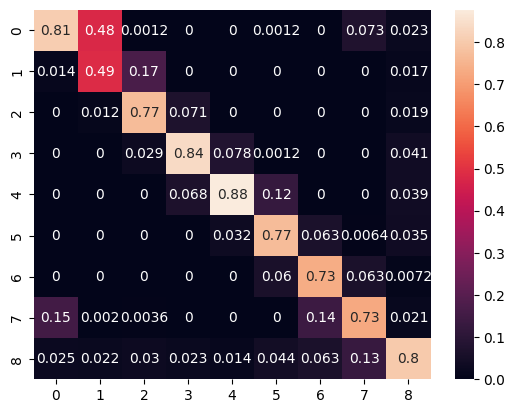

In [142]:
evaluate_classifier(lstm, X_test, y_test)

In [143]:
rmse_classifier = calculate_classifier_rmse(df, lstm, X_test, y_test)
print("RMSE classifier = {} rad = {} °". format(rmse_classifier, rmse_classifier*180/np.pi))

274/274 [==============================] - 1s 5ms/step
RMSE classifier = 0.8607290605031742 rad = 49.31614247109236 °


## 3h

In [127]:
lookback = 24
future = 3
X_train, y_train, X_test, y_test = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100_cat')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_outputs = y_train.shape[1]

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dense(n_outputs),
            Reshape([n_outputs*24]),
            Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            LSTM(24, activation='relu', return_sequences=True),
            Dropout(0.2),
            LSTM(24, activation='relu'),
            Dense(n_outputs, activation='softmax')
        ])

In [128]:
compile_and_fit(dense, X_train, y_train, X_test, y_test)
compile_and_fit(lstm, X_train, y_train, X_test, y_test)

Epoch 1/20
2191/2191 [==============================] - 15s 7ms/step - loss: 1.2109 - accuracy: 0.5487 - val_loss: 1.0881 - val_accuracy: 0.5955
Epoch 2/20
2191/2191 [==============================] - 15s 7ms/step - loss: 1.0358 - accuracy: 0.6108 - val_loss: 1.0112 - val_accuracy: 0.6221
Epoch 3/20
2191/2191 [==============================] - 15s 7ms/step - loss: 0.9917 - accuracy: 0.6225 - val_loss: 0.9838 - val_accuracy: 0.6302
Epoch 4/20
2191/2191 [==============================] - 15s 7ms/step - loss: 0.9701 - accuracy: 0.6303 - val_loss: 1.0281 - val_accuracy: 0.6060
Epoch 5/20
2191/2191 [==============================] - 16s 7ms/step - loss: 0.9521 - accuracy: 0.6350 - val_loss: 0.9498 - val_accuracy: 0.6429
Epoch 6/20
2191/2191 [==============================] - 16s 7ms/step - loss: 0.9435 - accuracy: 0.6378 - val_loss: 0.9578 - val_accuracy: 0.6370
Epoch 7/20
2191/2191 [==============================] - 16s 7ms/step - loss: 0.9327 - accuracy: 0.6390 - val_loss: 0.9786 - val_ac

274/274 [==============================] - 1s 2ms/step
0.6332077383995056 0.7890742586209224 0.6273030474881579


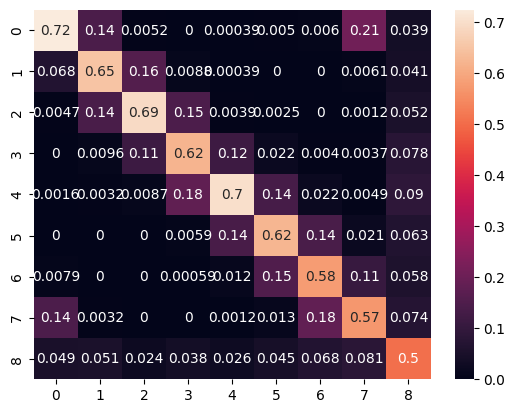

In [134]:
acc_dense, acc_corr_dense, f1_dense = evaluate_classifier(dense, X_test, y_test)

In [136]:
rmse_classifier = calculate_classifier_rmse(df, dense, X_test, y_test)
print("RMSE classifier = {} rad = {} °". format(rmse_classifier, rmse_classifier*180/np.pi))

274/274 [==============================] - 1s 2ms/step
RMSE classifier = 1.2188472633377734 rad = 69.83480406032486 °


274/274 [==============================] - 1s 5ms/step
0.5861596465110779 0.7304450979599586 0.5728933638468998


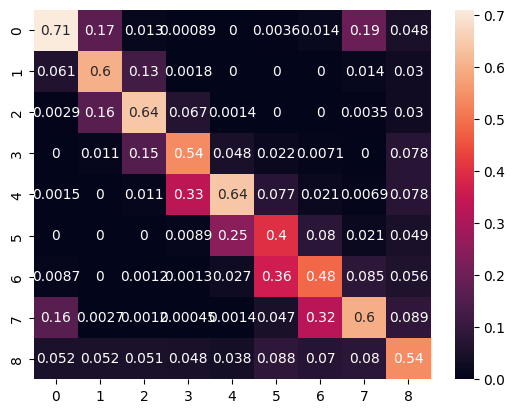

In [135]:
acc_lstm, acc_corr_lstm, f1_lstm = evaluate_classifier(lstm, X_test, y_test)

In [137]:
rmse_classifier = calculate_classifier_rmse(df, lstm, X_test, y_test)
print("RMSE classifier = {} rad = {} °". format(rmse_classifier, rmse_classifier*180/np.pi))

274/274 [==============================] - 1s 5ms/step
RMSE classifier = 1.1775434182065068 rad = 67.4682680566413 °


## 6h

In [144]:
lookback = 24
future = 6
X_train, y_train, X_test, y_test = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100_cat')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_outputs = y_train.shape[1]

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dense(n_outputs),
            Reshape([n_outputs*24]),
            Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            LSTM(24, activation='relu', return_sequences=True),
            Dropout(0.2),
            LSTM(24, activation='relu'),
            Dense(n_outputs, activation='softmax')
        ])

In [145]:
compile_and_fit(dense, X_train, y_train, X_test, y_test)
compile_and_fit(lstm, X_train, y_train, X_test, y_test)

Epoch 1/20
2191/2191 [==============================] - 14s 6ms/step - loss: 1.4508 - accuracy: 0.4517 - val_loss: 1.3679 - val_accuracy: 0.4925
Epoch 2/20
2191/2191 [==============================] - 14s 7ms/step - loss: 1.3109 - accuracy: 0.4995 - val_loss: 1.3376 - val_accuracy: 0.4922
Epoch 3/20
2191/2191 [==============================] - 15s 7ms/step - loss: 1.2725 - accuracy: 0.5125 - val_loss: 1.3111 - val_accuracy: 0.5034
Epoch 4/20
2191/2191 [==============================] - 14s 6ms/step - loss: 1.2537 - accuracy: 0.5165 - val_loss: 1.2917 - val_accuracy: 0.5107
Epoch 5/20
2191/2191 [==============================] - 14s 6ms/step - loss: 1.2365 - accuracy: 0.5229 - val_loss: 1.3078 - val_accuracy: 0.5001
Epoch 6/20
2191/2191 [==============================] - 14s 6ms/step - loss: 1.2236 - accuracy: 0.5285 - val_loss: 1.2873 - val_accuracy: 0.5102
Epoch 7/20
2191/2191 [==============================] - 14s 6ms/step - loss: 1.2110 - accuracy: 0.5324 - val_loss: 1.3121 - val_ac

274/274 [==============================] - 1s 2ms/step
0.5006853938102722 0.6239310292097239 0.4842358166207373


(0.5006853938102722, 0.6239310292097239, 0.4842358166207373)

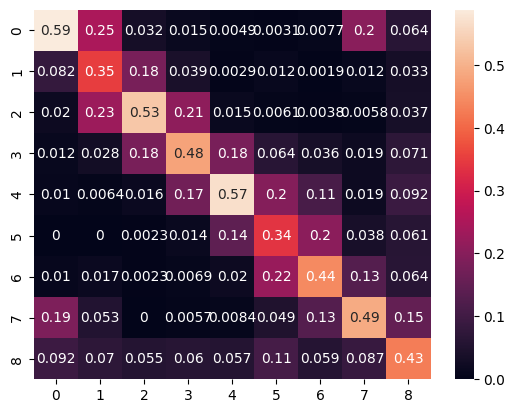

In [146]:
evaluate_classifier(dense, X_test, y_test)

In [147]:
rmse_classifier = calculate_classifier_rmse(df, dense, X_test, y_test)
print("RMSE classifier = {} rad = {} °". format(rmse_classifier, rmse_classifier*180/np.pi))

274/274 [==============================] - 1s 2ms/step
RMSE classifier = 1.3604019709793285 rad = 77.94529137839422 °


274/274 [==============================] - 2s 5ms/step
0.5030843019485474 0.6269204378128052 0.5006816374388975


(0.5030843019485474, 0.6269204378128052, 0.5006816374388975)

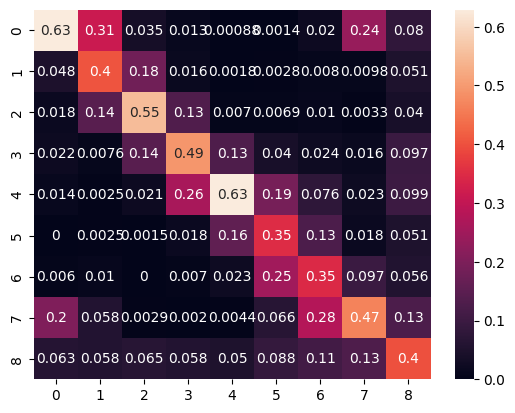

In [148]:
evaluate_classifier(lstm, X_test, y_test)

In [149]:
rmse_classifier = calculate_classifier_rmse(df, lstm, X_test, y_test)
print("RMSE classifier = {} rad = {} °". format(rmse_classifier, rmse_classifier*180/np.pi))

274/274 [==============================] - 2s 6ms/step
RMSE classifier = 1.3481427933142875 rad = 77.24289223788634 °


## Number of classes study

In [12]:
noClasses = [2,4,8,16]
rmses = []

for n in noClasses:
    df_local = df.copy()
    bins = np.linspace(-np.pi, np.pi, n+1)
    labels = range(n)
    df_local['wd_100_cat'] = pd.cut(df_local['wd_100'], bins=bins, include_lowest=True, labels=labels)

    weak_wind_class_limit = df_local['windspeed_100'].sort_values().iloc[int(len(df_local)/n)]

    df_local['wd_100_cat'] = df_local['wd_100_cat'].cat.add_categories(n)
    df_local['wd_100_cat'] = df_local['wd_100_cat'].where(df_local['windspeed_100']>weak_wind_class_limit, n)

    lookback = 24
    future = 6
    X_train, y_train, X_test, y_test = data_prep(df_local, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100_cat')
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    n_outputs = y_train.shape[1]

    dense = Sequential([
                Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
                Dropout(0.2),
                Dense(units=200, activation='relu'),
                Dropout(0.2),
                Dense(units=200, activation='relu'),
                Dense(n_outputs),
                Reshape([n_outputs*24]),
                Dense(n_outputs, activation='softmax'),
                # Reshape([1])
            ])
    compile_and_fit(dense, X_train, y_train, X_test, y_test)

    rmses.append(calculate_classifier_rmse(df_local, dense, X_test, y_test))


Epoch 1/20
2191/2191 [==============================] - 17s 7ms/step - loss: 0.7321 - accuracy: 0.6948 - val_loss: 0.6856 - val_accuracy: 0.7069
Epoch 2/20
2191/2191 [==============================] - 17s 8ms/step - loss: 0.6647 - accuracy: 0.7259 - val_loss: 0.6680 - val_accuracy: 0.7110
Epoch 3/20
2191/2191 [==============================] - 17s 8ms/step - loss: 0.6472 - accuracy: 0.7324 - val_loss: 0.6728 - val_accuracy: 0.7110
Epoch 4/20
2191/2191 [==============================] - 20s 9ms/step - loss: 0.6383 - accuracy: 0.7336 - val_loss: 0.6506 - val_accuracy: 0.7239
Epoch 5/20
2191/2191 [==============================] - 18s 8ms/step - loss: 0.6294 - accuracy: 0.7377 - val_loss: 0.6540 - val_accuracy: 0.7169
Epoch 6/20
2191/2191 [==============================] - 19s 9ms/step - loss: 0.6241 - accuracy: 0.7383 - val_loss: 0.6505 - val_accuracy: 0.7180
Epoch 7/20
2191/2191 [==============================] - 17s 8ms/step - loss: 0.6200 - accuracy: 0.7412 - val_loss: 0.6570 - val_ac

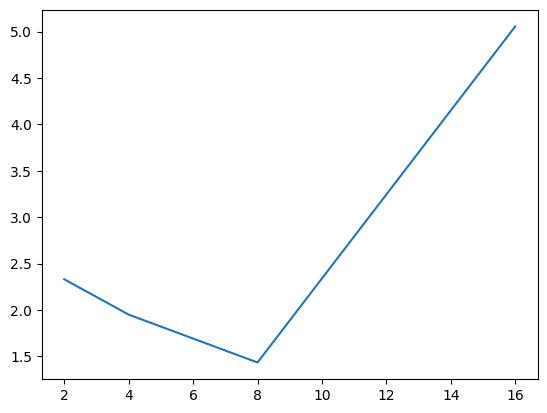

In [13]:
plt.plot(noClasses, rmses)

In [14]:
n = 12
df_local = df.copy()
bins = np.linspace(-np.pi, np.pi, n+1)
labels = range(n)
df_local['wd_100_cat'] = pd.cut(df_local['wd_100'], bins=bins, include_lowest=True, labels=labels)

weak_wind_class_limit = df_local['windspeed_100'].sort_values().iloc[int(len(df_local)/n)]

df_local['wd_100_cat'] = df_local['wd_100_cat'].cat.add_categories(n)
df_local['wd_100_cat'] = df_local['wd_100_cat'].where(df_local['windspeed_100']>weak_wind_class_limit, n)

lookback = 24
future = 6
X_train, y_train, X_test, y_test = data_prep(df_local, 2012, 2019, 2020, 2020, lookback, future, y_featurename='wd_100_cat')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_outputs = y_train.shape[1]

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dense(n_outputs),
            Reshape([n_outputs*24]),
            Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])
compile_and_fit(dense, X_train, y_train, X_test, y_test)
rmse_12 = calculate_classifier_rmse(df_local, dense, X_test, y_test)

Epoch 1/20
2191/2191 [==============================] - 17s 8ms/step - loss: 1.7975 - accuracy: 0.3417 - val_loss: 1.6948 - val_accuracy: 0.3635
Epoch 2/20
2191/2191 [==============================] - 16s 7ms/step - loss: 1.6467 - accuracy: 0.3863 - val_loss: 1.6466 - val_accuracy: 0.3762
Epoch 3/20
2191/2191 [==============================] - 16s 7ms/step - loss: 1.6038 - accuracy: 0.4033 - val_loss: 1.6345 - val_accuracy: 0.3893
Epoch 4/20
2191/2191 [==============================] - 16s 7ms/step - loss: 1.5777 - accuracy: 0.4112 - val_loss: 1.6395 - val_accuracy: 0.3805
Epoch 5/20
2191/2191 [==============================] - 17s 8ms/step - loss: 1.5568 - accuracy: 0.4174 - val_loss: 1.6149 - val_accuracy: 0.3852
Epoch 6/20
2191/2191 [==============================] - 17s 8ms/step - loss: 1.5352 - accuracy: 0.4253 - val_loss: 1.6465 - val_accuracy: 0.3684
Epoch 7/20
2191/2191 [==============================] - 17s 8ms/step - loss: 1.5219 - accuracy: 0.4286 - val_loss: 1.6192 - val_ac

In [17]:
rses_new = rmses[:3]+[rmse_12]+[rmses[-1]]

Text(0, 0.5, 'Custom classification RMSE metric value')

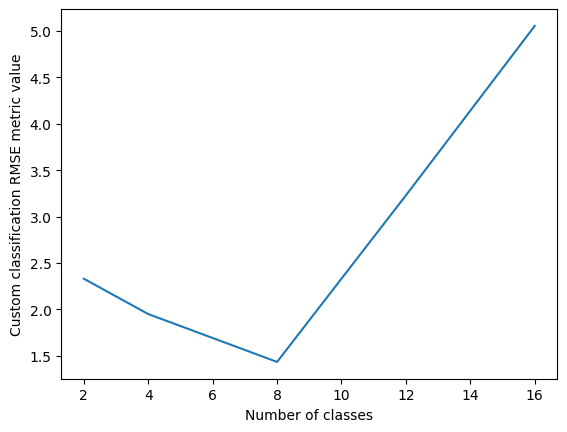

In [24]:
plt.plot([2,4,8,12,16], rses_new)
plt.xlabel("Number of classes")
plt.ylabel("Custom classification RMSE metric value")

In [22]:
rses_new

[2.3313371475555953,
 1.950689766811687,
 1.4349027136419537,
 3.2294605303740505,
 5.055364377093395]